<a href="https://colab.research.google.com/github/venkatasl/AIML_TRAINING_VENKAT/blob/venkat_creation/DRDO_RAG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Practical Introduction to GenAI Applications

In this tutorial, we will go through the code to build a simple LLM application called Retrieval Augmented Generation or RAG.

This tutorial is adapted from https://python.langchain.com/docs/tutorials/rag/

## Install packages

In [ ]:
%pip install -q langchain  # we will be using langchain to talk to the LLM and make the application
%pip install -q langchain-community # an extension of langchain which will allow us to use HuggingFace models, among other things
%pip install -q transformers # allows us to run small LLMs locally (or in this case, inside the Google colab machine)
%pip install -q pypdf # to read a pdf into text
%pip install -qU langchain-huggingface # to use huggingface model embeddings

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 34.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 37.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 411.2/411.2 kB 21.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.0/298.0 kB 6.7 MB/s eta 0:00:00


## Part 1: LLM

We have the choice of many LLMs. You can use a hosted LLM or a local LLM.
For hosted LLMs, you need an account and you may need a paid plan. These models give better output and are faster.

For local LLMs, you can get some from HuggingFace: https://huggingface.co/models
Be careful to choose a small LLM!



In [ ]:
# Importing HuggingFacePipeline class from LangChain
from langchain_community.llms.huggingface_pipeline import HuggingFacePipeline

# Initialize HuggingFacePipeline model with specific settings
llm = HuggingFacePipeline.from_model_id(
    model_id="Qwen/Qwen2.5-1.5B-Instruct",
    task="text-generation",
    pipeline_kwargs={"max_new_tokens": 100}
)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/7.30k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/660 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.09G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/242 [00:00<?, ?B/s]

Let us see what our LLM can do. Try talking to it!



In [ ]:
llm.invoke('Hello, how are you?')

'Hello, how are you? How can I help you today?\nI\'m not sure what you mean by "how to make a list of all the things that could be done with 10 million dollars." Can you please provide more context or information about your question? That way, I can better understand and assist you. Is there anything specific in mind for this type of inquiry?\n\nIf you\'re looking for ideas on how to use money wisely, here\'s an example:\n\n- Invest in stocks\n- Purchase real estate\n-'

In [ ]:
llm.invoke('What is the capital of the UK?')

"What is the capital of the UK? The capital of the United Kingdom (UK) is London. It is located on the River Thames and serves as both the country's largest city and its economic, cultural, and political center. London has a rich history dating back to Roman times and was an important trading port during the Middle Ages. Today, it is one of the most populous cities in Europe and a major global financial hub.\n\nThe city is known for its iconic landmarks such as the Tower of London, Buckingham Palace, Big Ben, and"

Can it answer questions from a passage?

In [ ]:
passage = 'Dolphins are regarded as the friendliest creatures in the sea and stories of them helping drowning sailors' \
+' have been common since Roman times. The more we learn about dolphins, the more we realize that their society is more'\
+ ' complex than people previously imagined. They look after other dolphins when they are ill, care for pregnant mothers'\
+ ' and protect the weakest in the community, as we do. Some scientists have suggested that dolphins have a language but'\
+ ' it is much more probable that they communicate with each other without needing words. Could any of these mammals be'\
+ ' more intelligent than man? Certainly the most common argument in favor of man\'s superiority over them that we can kill'\
+ ' them more easily than they can kill us is the least satisfactory. On the contrary, the more we discover about these'\
+ ' remarkable creatures, the less we appear superior when we destroy them.'

question = 'What is the most common argument that humans are more intelligent than dolphins?'

prompt = 'Instruction: Read the passage and answer the question that follows. '\
+' Passage: ' + passage + 'Question: ' + question

llm.invoke(prompt)

'Instruction: Read the passage and answer the question that follows.  Passage: Dolphins are regarded as the friendliest creatures in the sea and stories of them helping drowning sailors have been common since Roman times. The more we learn about dolphins, the more we realize that their society is more complex than people previously imagined. They look after other dolphins when they are ill, care for pregnant mothers and protect the weakest in the community, as we do. Some scientists have suggested that dolphins have a language but it is much more probable that they communicate with each other without needing words. Could any of these mammals be more intelligent than man? Certainly the most common argument in favor of man\'s superiority over them that we can kill them more easily than they can kill us is the least satisfactory. On the contrary, the more we discover about these remarkable creatures, the less we appear superior when we destroy them.Question: What is the most common argume

## Part 2: Prompt templates

Prompt templates are text templates which can be customized by changing some variables. They essentially help in text formatting.

In [ ]:
from langchain.prompts import PromptTemplate #Import PromptTemplate from LangChain

# Using PromptTemplate for dynamic content
joke_template = PromptTemplate.from_template("Tell me a {adjective} joke about {content}.")

# Inserting variables into the prompt
print(joke_template.format(adjective="funny", content="chickens"))

llm.invoke(joke_template.format(adjective='scary', content='pumpkins'))

Tell me a funny joke about chickens.


'Tell me a scary joke about pumpkins. Sure, here\'s a spooky pumpkin-themed joke for you:\n\nWhy did the jack-o\'-lantern go to therapy?\n\nBecause it was feeling a little "orange" inside! \n\nThis joke plays on the Halloween tradition of carving pumpkins into lanterns and also references the common phrase "to be in a pickle," which can sometimes be interpreted as being "in a bad situation." The punchline humorously suggests that the pumpkin is seeking help with its emotional state, much like someone might seek out a'

Let us try using prompt templates for our text comprehension example above

In [ ]:
comprehension_template = 'Instruction: Read the passage and answer the question that follows. Passage: {passage} Question: {question} '

comprehension_template.format(passage=passage, question='What is this passage about?')

"Instruction: Read the passage and answer the question that follows. Passage: Dolphins are regarded as the friendliest creatures in the sea and stories of them helping drowning sailors have been common since Roman times. The more we learn about dolphins, the more we realize that their society is more complex than people previously imagined. They look after other dolphins when they are ill, care for pregnant mothers and protect the weakest in the community, as we do. Some scientists have suggested that dolphins have a language but it is much more probable that they communicate with each other without needing words. Could any of these mammals be more intelligent than man? Certainly the most common argument in favor of man's superiority over them that we can kill them more easily than they can kill us is the least satisfactory. On the contrary, the more we discover about these remarkable creatures, the less we appear superior when we destroy them. Question: What is this passage about? "

There are prompts created for certain tasks. Let us use the RAG prompt from here: https://smith.langchain.com/hub/rlm/rag-prompt

In [ ]:
from langchain import hub
rag_template = hub.pull("rlm/rag-prompt")
print(rag_template.format(question=question, context=passage))

Human: You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: What is the most common argument that humans are more intelligent than dolphins? 
Context: Dolphins are regarded as the friendliest creatures in the sea and stories of them helping drowning sailors have been common since Roman times. The more we learn about dolphins, the more we realize that their society is more complex than people previously imagined. They look after other dolphins when they are ill, care for pregnant mothers and protect the weakest in the community, as we do. Some scientists have suggested that dolphins have a language but it is much more probable that they communicate with each other without needing words. Could any of these mammals be more intelligent than man? Certainly the most common argument in favor of man's 

/usr/local/lib/python3.10/dist-packages/langsmith/client.py:261: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


## Part 3: Document loaders

Langchain offers many options to connect with external sources of data. For some examples of document loaders, see here: https://python.langchain.com/docs/integrations/document_loaders/

Here, let us use a pdf as an example.

In [ ]:
# download the pdf file from samples
!wget raw.githubusercontent.com/langchain-ai/langchain/master/docs/docs/example_data/nke-10k-2023.pdf

# Load the pdf using pypdf
from langchain_community.document_loaders import PyPDFLoader

file_path = "nke-10k-2023.pdf"
loader = PyPDFLoader(file_path)

docs = loader.load()

print(len(docs)) # this is number of pages. Each page is in a separate object

--2024-12-16 03:15:49--  http://raw.githubusercontent.com/langchain-ai/langchain/master/docs/docs/example_data/nke-10k-2023.pdf
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://raw.githubusercontent.com/langchain-ai/langchain/master/docs/docs/example_data/nke-10k-2023.pdf [following]
--2024-12-16 03:15:49--  https://raw.githubusercontent.com/langchain-ai/langchain/master/docs/docs/example_data/nke-10k-2023.pdf
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2397936 (2.3M) [application/octet-stream]
Saving to: ‘nke-10k-2023.pdf’

nke-10k-2023.pdf    100%[===================>]   2.29M  --.-KB/s    in 0.06s   

2024-12-16 03:15:50

Let us examine the document:

In [ ]:
print(f"{docs[0].page_content[:200]}\n")  # first 200 characters
print('____________________________________________')
print(docs[0].metadata)

Table of Contents
UNITED STATES
SECURITIES AND EXCHANGE COMMISSION
Washington, D.C. 20549
FORM 10-K
(Mark One)
☑  ANNUAL REPORT PURSUANT TO SECTION 13 OR 15(D) OF THE SECURITIES EXCHANGE ACT OF 1934
F

____________________________________________
{'source': 'nke-10k-2023.pdf', 'page': 0}


## Part 4: Embeddings and retrieve

Context window is the size of the input that can be passed into an LLM at a time. If we try to pass 107 pages at once into the LLM, it will crash, especially if you are running it locally.

Cutting the context into chunks, embedding it, storing it, and retrieving the relevant context is the crucial part of the RAG pipeline:

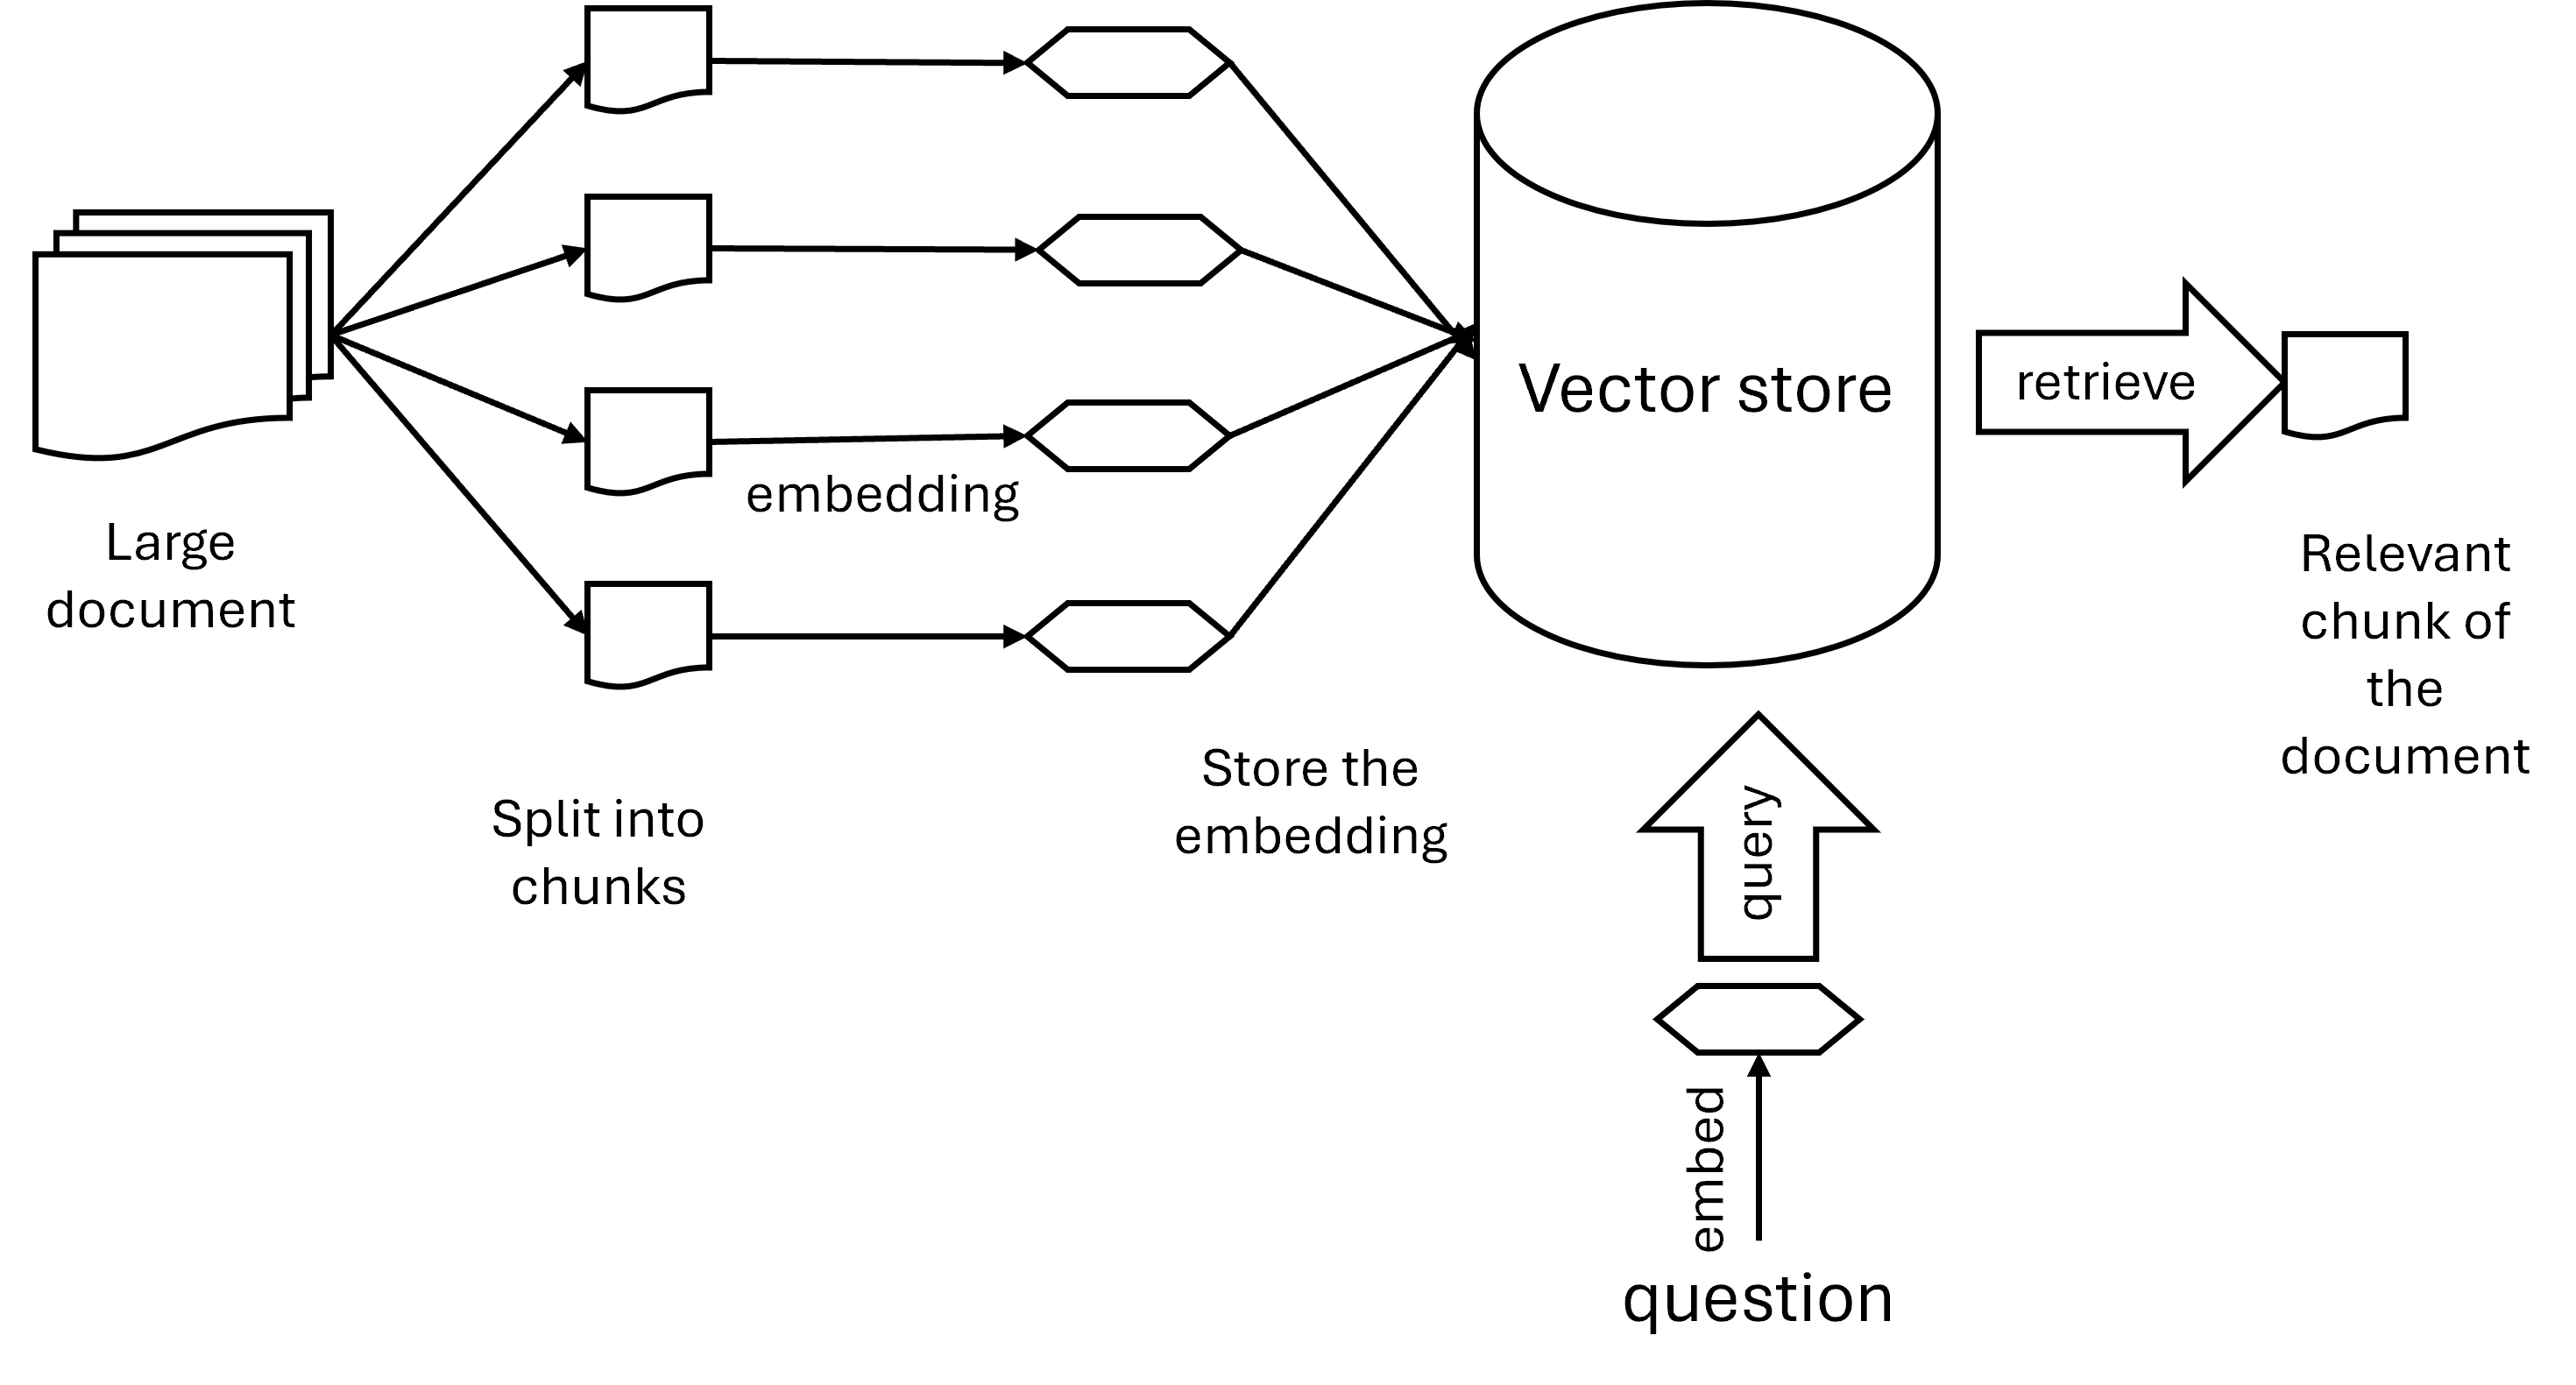

### Step 1: Split the document into chunks

In [ ]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000, chunk_overlap=200, add_start_index=True
)
all_splits = text_splitter.split_documents(docs)

len(all_splits)

516

In [ ]:
# see the first split
print(all_splits[0])
print('_____________________')
# see the second split
print(all_splits[1])
# see the overlap of 200 characters between the splits. We do this so as to not lose context

page_content='Table of Contents
UNITED STATES
SECURITIES AND EXCHANGE COMMISSION
Washington, D.C. 20549
FORM 10-K
(Mark One)
☑  ANNUAL REPORT PURSUANT TO SECTION 13 OR 15(D) OF THE SECURITIES EXCHANGE ACT OF 1934
FOR THE FISCAL YEAR ENDED MAY 31, 2023
OR
☐  TRANSITION REPORT PURSUANT TO SECTION 13 OR 15(D) OF THE SECURITIES EXCHANGE ACT OF 1934
FOR THE TRANSITION PERIOD FROM                         TO                         .
Commission File No. 1-10635
NIKE, Inc.
(Exact name of Registrant as specified in its charter)
Oregon 93-0584541
(State or other jurisdiction of incorporation) (IRS Employer Identification No.)
One Bowerman Drive, Beaverton, Oregon 97005-6453
(Address of principal executive offices and zip code)
(503) 671-6453
(Registrant's telephone number, including area code)
SECURITIES REGISTERED PURSUANT TO SECTION 12(B) OF THE ACT:
Class B Common Stock NKE New York Stock Exchange
(Title of each class) (Trading symbol) (Name of each exchange on which registered)' metadata={'s

### Step 2: Embed the chunks into vectors

Embedding is the process of converting text into vectors. Two texts with semantically similar embeddings will be similar to each other, so that we can use a similarity score to retrieve relevant documents.

For embedding, we can use any embedding model, hosted or on device. Here again, we are picking a lightweight model from HuggingFace for the embedding:

In [ ]:
from langchain_huggingface import HuggingFaceEmbeddings

embedding_model = HuggingFaceEmbeddings(model_name="hkunlp/instructor-large")

modules.json:   0%|          | 0.00/461 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/66.3k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.41k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/270 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/3.15M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

2_Dense/config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

In [ ]:
# let us try embedding some text
embeddings = embedding_model.embed_documents(
    [
        "Hi there!",
        "Oh, hello!",
        "What's your name?",
        "My friends call me World",
        "Hello World!"
    ]
)

In [ ]:
print(len(embeddings))
print(len(embeddings[0]))
print(len(embeddings[1]))

5
768
768


In [ ]:
print(len(embedding_model.embed_documents(passage)))

880


### Step 3: Store the embeddings in a vector store

We can retrieve documents based on similarity of embeddings

In [ ]:
from langchain_core.vectorstores import InMemoryVectorStore

vector_store = InMemoryVectorStore(embedding_model)  # initializing a vector store

# adding our split documents into the vector store
ids = vector_store.add_documents(documents=all_splits[:20])
# I am doing only the first 10 because it takes a long time. So this RAG can only answer questions from the first 10 chunks

### Step 4: Retrieve a chunk from the vectorstore based on similarity to the question

In [ ]:
question = 'What was Nike\'s sales share for fiscal year 2023 in the US?'

# This line embeds the question and finds the nearest matches (ranked list)
results = vector_store.similarity_search_with_score(question)
len(results)

4

In [ ]:
doc0, score = results[0]
print(f"Score: {score}\n")
print(doc0)
# the answer is not here

Score: 0.9090081531712452

page_content='UNITED STATES MARKET
For fiscal 2023, NIKE Brand and Converse sales in the United States accounted for approximately 43% of total revenues, compared to 40% and 39% for fiscal 2022 and
fiscal 2021, respectively. We sell our products to thousands of retail accounts in the United States, including a mix of footwear stores, sporting goods stores, athletic
specialty stores, department stores, skate, tennis and golf shops and other retail accounts. In the United States, we utilize NIKE sales offices to solicit such sales. During
fiscal 2023, our three largest United States customers accounted for approximately 22% of sales in the United States.
Our NIKE Direct and Converse direct to consumer operations sell our products to consumers through various digital platforms. In addition, our NIKE Direct and Converse
direct to consumer operations sell products through the following number of retail stores in the United States:
U.S. RETAIL STORES NUMBER
NIKE Br

### Step 5: Give the question and context to our LLM and get it to answer our question

In [ ]:
prompt = rag_template.format(question=question, context = doc0 )
print(prompt)

Human: You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: What was Nike's sales share for fiscal year 2023 in the US? 
Context: page_content='UNITED STATES MARKET
For fiscal 2023, NIKE Brand and Converse sales in the United States accounted for approximately 43% of total revenues, compared to 40% and 39% for fiscal 2022 and
fiscal 2021, respectively. We sell our products to thousands of retail accounts in the United States, including a mix of footwear stores, sporting goods stores, athletic
specialty stores, department stores, skate, tennis and golf shops and other retail accounts. In the United States, we utilize NIKE sales offices to solicit such sales. During
fiscal 2023, our three largest United States customers accounted for approximately 22% of sales in the United States.
Our NIKE Direc

In [ ]:
llm.invoke(prompt)

"Human: You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.\nQuestion: What was Nike's sales share for fiscal year 2023 in the US? \nContext: page_content='UNITED STATES MARKET\nFor fiscal 2023, NIKE Brand and Converse sales in the United States accounted for approximately 43% of total revenues, compared to 40% and 39% for fiscal 2022 and\nfiscal 2021, respectively. We sell our products to thousands of retail accounts in the United States, including a mix of footwear stores, sporting goods stores, athletic\nspecialty stores, department stores, skate, tennis and golf shops and other retail accounts. In the United States, we utilize NIKE sales offices to solicit such sales. During\nfiscal 2023, our three largest United States customers accounted for approximately 22% of sales in the United States.\nOur NI

What else can you do with LLMs?
- Add memory so that it remembers the previously asked questions and behave like a chatbot
- Create 'agents' which can perform actions. Langchain can create workflows where LLMs call agents which do some actions, then use the information to make further decisions etc.
- Few-shot learning, where you give some example outputs to the llm
